# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

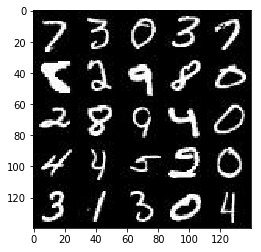

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

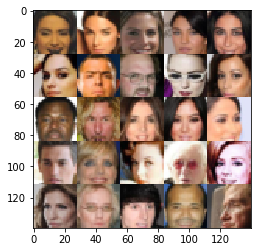

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/u/.local/virtualenvs/dl/lib/python3.6/site-packages/zmq/eventloop/ioloop.

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Image 7x7x128
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Image 4x4x256
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Image 7x7x1024
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        
        # Image 14x14x512
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        relu = tf.nn.relu(layer)
         
        # Image 28x28x256
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        layer = tf.image.resize_images(layer, size=(28, 28)) 
        
        output = tf.nn.tanh(layer, name='generator_main')
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smooth = 0.1
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                         labels=tf.ones_like(discriminator_real_model) * (1 - smooth)))
    
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                         labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                    labels = tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
 
    discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = discriminator_vars)
    
    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_dep = [dep for dep in deps if dep.name.startswith("generator")]
    
    with tf.control_dependencies(generator_dep):
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = generator_vars)
    
    return discriminator_opt, generator_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_w, image_h, out_channel_dim = data_shape
    input_ph, z_ph, lr_ph = model_inputs(image_w, image_h, out_channel_dim, z_dim)
    d_loss,g_loss = model_loss(input_ph, z_ph, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_ph, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Epoch {}/{}'.format(epoch_i+1, epoch_count))
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_train_opt, feed_dict={
                    input_ph: batch_images,
                    z_ph: batch_z,
                    lr_ph:learning_rate})
                sess.run(g_train_opt, feed_dict={
                    z_ph: batch_z,
#                     input_ph: batch_images,
                    lr_ph:learning_rate})

                if steps % 16 == 0:
                    train_loss_d = d_loss.eval({z_ph: batch_z, input_ph: batch_images})
                    train_loss_g = g_loss.eval({z_ph: batch_z})

                    print("Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % batch_size == 0:
                    show_generator_output(sess, 9, z_ph, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2
Step 16... Discriminator Loss: 2.4490... Generator Loss: 0.1838
Step 32... Discriminator Loss: 1.9071... Generator Loss: 0.4060
Step 48... Discriminator Loss: 1.3412... Generator Loss: 0.8087
Step 64... Discriminator Loss: 1.6517... Generator Loss: 0.5784


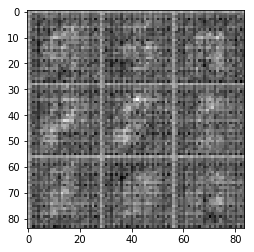

Step 80... Discriminator Loss: 1.6394... Generator Loss: 0.5029
Step 96... Discriminator Loss: 1.5112... Generator Loss: 0.6385
Step 112... Discriminator Loss: 1.3665... Generator Loss: 0.8723
Step 128... Discriminator Loss: 1.4865... Generator Loss: 0.5949


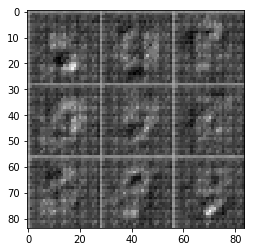

Step 144... Discriminator Loss: 1.3397... Generator Loss: 0.8704
Step 160... Discriminator Loss: 1.4599... Generator Loss: 0.6164
Step 176... Discriminator Loss: 1.3866... Generator Loss: 0.8102
Step 192... Discriminator Loss: 1.3461... Generator Loss: 0.8429


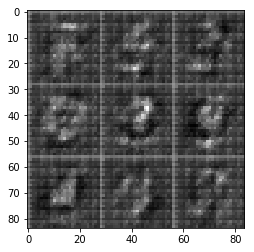

Step 208... Discriminator Loss: 1.4442... Generator Loss: 0.6011
Step 224... Discriminator Loss: 1.3646... Generator Loss: 0.6325
Step 240... Discriminator Loss: 1.3011... Generator Loss: 0.7144
Step 256... Discriminator Loss: 1.3456... Generator Loss: 0.6221


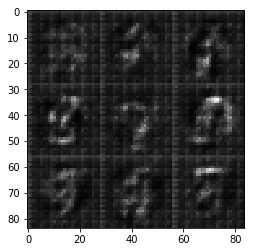

Step 272... Discriminator Loss: 1.2961... Generator Loss: 0.7122
Step 288... Discriminator Loss: 1.3634... Generator Loss: 0.5797
Step 304... Discriminator Loss: 1.3271... Generator Loss: 0.6762
Step 320... Discriminator Loss: 1.2348... Generator Loss: 0.7073


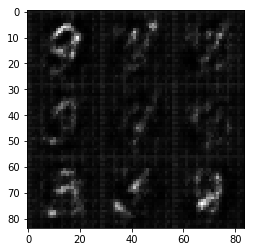

Step 336... Discriminator Loss: 1.1989... Generator Loss: 0.7558
Step 352... Discriminator Loss: 1.1773... Generator Loss: 1.1234
Step 368... Discriminator Loss: 1.3062... Generator Loss: 0.5503
Step 384... Discriminator Loss: 1.1647... Generator Loss: 0.8774


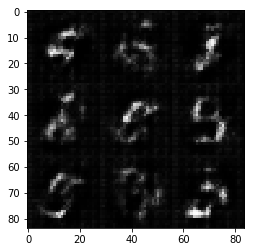

Step 400... Discriminator Loss: 1.0647... Generator Loss: 1.0659
Step 416... Discriminator Loss: 1.1117... Generator Loss: 1.0421
Step 432... Discriminator Loss: 1.1432... Generator Loss: 0.8769
Step 448... Discriminator Loss: 1.1964... Generator Loss: 1.2075


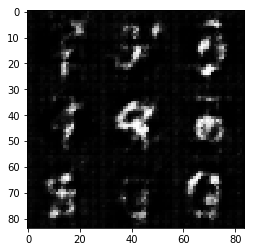

Step 464... Discriminator Loss: 1.0985... Generator Loss: 1.0336
Step 480... Discriminator Loss: 1.1435... Generator Loss: 0.8646
Step 496... Discriminator Loss: 1.1162... Generator Loss: 1.1016
Step 512... Discriminator Loss: 1.1944... Generator Loss: 0.7299


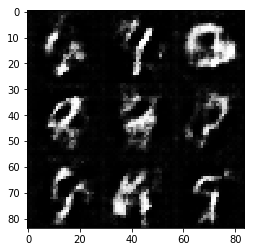

Step 528... Discriminator Loss: 1.4453... Generator Loss: 0.4369
Step 544... Discriminator Loss: 1.2682... Generator Loss: 0.5812
Step 560... Discriminator Loss: 1.2605... Generator Loss: 0.6358
Step 576... Discriminator Loss: 1.3852... Generator Loss: 0.4844


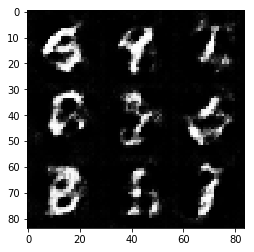

Step 592... Discriminator Loss: 1.2325... Generator Loss: 0.7249
Step 608... Discriminator Loss: 1.1354... Generator Loss: 0.9804
Step 624... Discriminator Loss: 1.2201... Generator Loss: 0.9810
Step 640... Discriminator Loss: 1.4107... Generator Loss: 0.5126


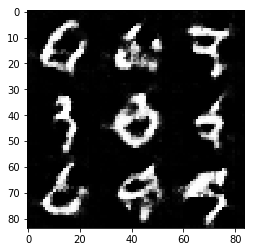

Step 656... Discriminator Loss: 1.2705... Generator Loss: 0.6459
Step 672... Discriminator Loss: 1.2791... Generator Loss: 0.6128
Step 688... Discriminator Loss: 1.2952... Generator Loss: 0.8679
Step 704... Discriminator Loss: 1.2582... Generator Loss: 0.8041


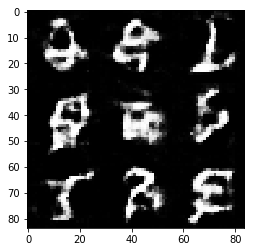

Step 720... Discriminator Loss: 1.2571... Generator Loss: 0.7541
Step 736... Discriminator Loss: 1.2103... Generator Loss: 0.8455
Step 752... Discriminator Loss: 1.2886... Generator Loss: 0.9286
Step 768... Discriminator Loss: 1.2937... Generator Loss: 0.8574


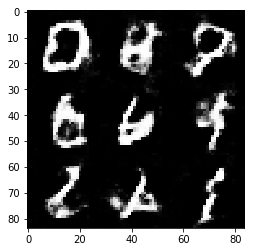

Step 784... Discriminator Loss: 1.3230... Generator Loss: 0.8045
Step 800... Discriminator Loss: 1.2622... Generator Loss: 0.6656
Step 816... Discriminator Loss: 1.5174... Generator Loss: 0.4241
Step 832... Discriminator Loss: 1.2721... Generator Loss: 0.7304


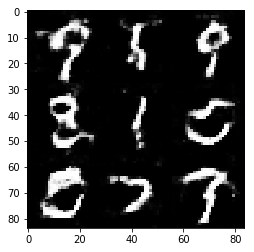

Step 848... Discriminator Loss: 1.2656... Generator Loss: 1.0533
Step 864... Discriminator Loss: 1.3078... Generator Loss: 0.9615
Step 880... Discriminator Loss: 1.3186... Generator Loss: 0.7141
Step 896... Discriminator Loss: 1.2540... Generator Loss: 0.8789


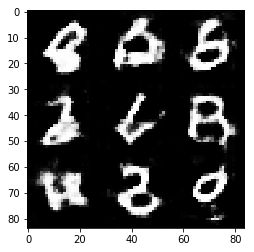

Step 912... Discriminator Loss: 1.3540... Generator Loss: 0.9104
Step 928... Discriminator Loss: 1.3777... Generator Loss: 0.5352
Epoch 2/2
Step 944... Discriminator Loss: 1.3057... Generator Loss: 1.2642
Step 960... Discriminator Loss: 1.2373... Generator Loss: 0.7247


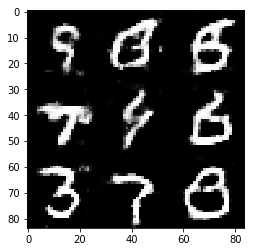

Step 976... Discriminator Loss: 1.3174... Generator Loss: 0.7009
Step 992... Discriminator Loss: 1.2724... Generator Loss: 0.9994
Step 1008... Discriminator Loss: 1.3491... Generator Loss: 0.5600
Step 1024... Discriminator Loss: 1.2004... Generator Loss: 0.8927


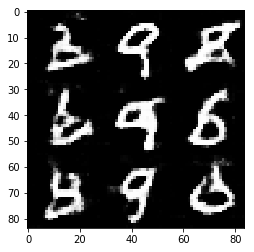

Step 1040... Discriminator Loss: 1.3795... Generator Loss: 0.6182
Step 1056... Discriminator Loss: 1.2899... Generator Loss: 0.8417
Step 1072... Discriminator Loss: 1.1922... Generator Loss: 0.8158
Step 1088... Discriminator Loss: 1.3002... Generator Loss: 0.6725


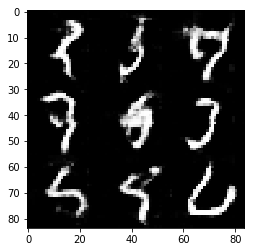

Step 1104... Discriminator Loss: 1.2320... Generator Loss: 0.9505
Step 1120... Discriminator Loss: 1.4130... Generator Loss: 0.5294
Step 1136... Discriminator Loss: 1.3087... Generator Loss: 1.2443
Step 1152... Discriminator Loss: 1.3425... Generator Loss: 0.6033


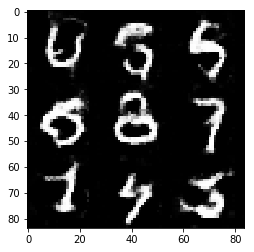

Step 1168... Discriminator Loss: 1.4915... Generator Loss: 0.4435
Step 1184... Discriminator Loss: 1.3024... Generator Loss: 0.7204
Step 1200... Discriminator Loss: 1.3357... Generator Loss: 0.6204
Step 1216... Discriminator Loss: 1.2645... Generator Loss: 0.8221


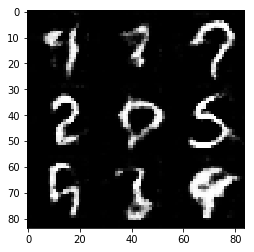

Step 1232... Discriminator Loss: 1.2823... Generator Loss: 0.9182
Step 1248... Discriminator Loss: 1.1802... Generator Loss: 0.7964
Step 1264... Discriminator Loss: 1.4848... Generator Loss: 0.4390
Step 1280... Discriminator Loss: 1.2870... Generator Loss: 1.1249


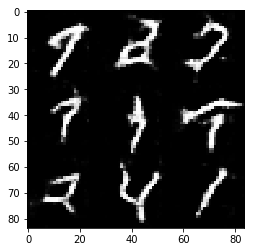

Step 1296... Discriminator Loss: 1.3524... Generator Loss: 0.6203
Step 1312... Discriminator Loss: 1.2648... Generator Loss: 0.7748
Step 1328... Discriminator Loss: 1.3161... Generator Loss: 0.6522
Step 1344... Discriminator Loss: 1.4174... Generator Loss: 0.5028


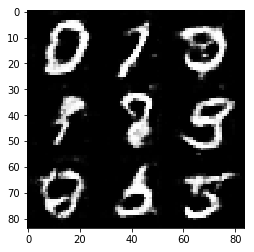

Step 1360... Discriminator Loss: 1.1981... Generator Loss: 0.8266
Step 1376... Discriminator Loss: 1.2079... Generator Loss: 1.2766
Step 1392... Discriminator Loss: 1.2127... Generator Loss: 1.1897
Step 1408... Discriminator Loss: 1.2048... Generator Loss: 0.8820


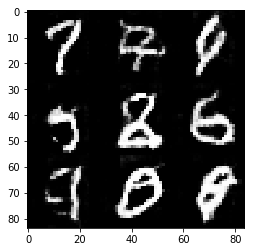

Step 1424... Discriminator Loss: 1.4096... Generator Loss: 0.5716
Step 1440... Discriminator Loss: 1.3399... Generator Loss: 0.6077
Step 1456... Discriminator Loss: 1.4439... Generator Loss: 0.4691
Step 1472... Discriminator Loss: 1.2586... Generator Loss: 0.6834


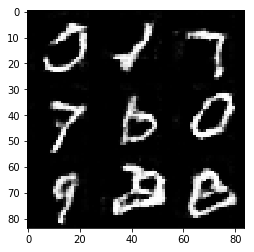

Step 1488... Discriminator Loss: 1.2196... Generator Loss: 0.8737
Step 1504... Discriminator Loss: 1.2343... Generator Loss: 0.9720
Step 1520... Discriminator Loss: 1.1676... Generator Loss: 1.1601
Step 1536... Discriminator Loss: 1.4407... Generator Loss: 0.5025


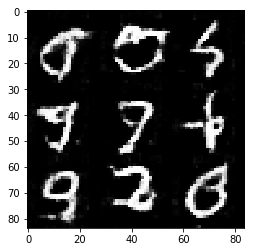

Step 1552... Discriminator Loss: 1.2896... Generator Loss: 0.8925
Step 1568... Discriminator Loss: 1.3450... Generator Loss: 0.5598
Step 1584... Discriminator Loss: 1.1645... Generator Loss: 1.1854
Step 1600... Discriminator Loss: 1.3588... Generator Loss: 1.1723


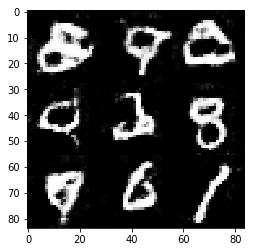

Step 1616... Discriminator Loss: 1.1403... Generator Loss: 0.9238
Step 1632... Discriminator Loss: 1.1620... Generator Loss: 1.2014
Step 1648... Discriminator Loss: 1.2546... Generator Loss: 0.9627
Step 1664... Discriminator Loss: 1.1361... Generator Loss: 1.1763


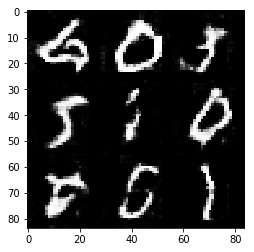

Step 1680... Discriminator Loss: 1.2540... Generator Loss: 0.9170
Step 1696... Discriminator Loss: 1.1585... Generator Loss: 0.9957
Step 1712... Discriminator Loss: 1.3423... Generator Loss: 0.5433
Step 1728... Discriminator Loss: 1.1782... Generator Loss: 0.8911


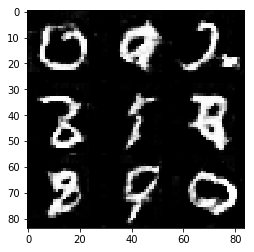

Step 1744... Discriminator Loss: 1.2466... Generator Loss: 1.1190
Step 1760... Discriminator Loss: 1.2868... Generator Loss: 0.5845
Step 1776... Discriminator Loss: 1.3627... Generator Loss: 0.5317
Step 1792... Discriminator Loss: 1.2627... Generator Loss: 0.6073


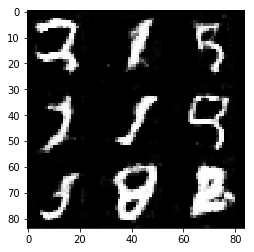

Step 1808... Discriminator Loss: 1.3206... Generator Loss: 0.6448
Step 1824... Discriminator Loss: 1.2342... Generator Loss: 0.8129
Step 1840... Discriminator Loss: 1.6232... Generator Loss: 0.3518
Step 1856... Discriminator Loss: 1.1423... Generator Loss: 0.9510


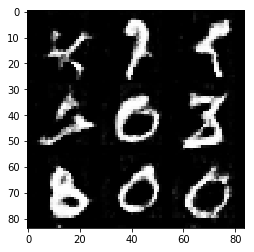

Step 1872... Discriminator Loss: 1.3427... Generator Loss: 0.5700


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1
Step 16... Discriminator Loss: 5.7003... Generator Loss: 0.0106
Step 32... Discriminator Loss: 3.1685... Generator Loss: 0.1373
Step 48... Discriminator Loss: 2.7593... Generator Loss: 0.2472
Step 64... Discriminator Loss: 2.0621... Generator Loss: 0.3360


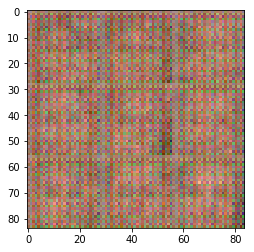

Step 80... Discriminator Loss: 2.0541... Generator Loss: 0.3853
Step 96... Discriminator Loss: 2.2748... Generator Loss: 0.3755
Step 112... Discriminator Loss: 2.1382... Generator Loss: 0.4418
Step 128... Discriminator Loss: 1.9912... Generator Loss: 0.4767


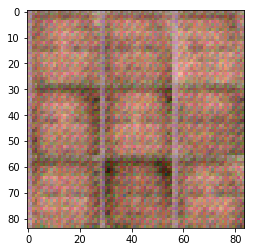

Step 144... Discriminator Loss: 1.7912... Generator Loss: 0.5287
Step 160... Discriminator Loss: 1.8418... Generator Loss: 0.5274
Step 176... Discriminator Loss: 1.7776... Generator Loss: 0.5425
Step 192... Discriminator Loss: 1.8063... Generator Loss: 0.5569


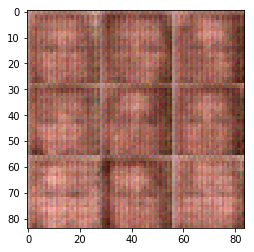

Step 208... Discriminator Loss: 1.6362... Generator Loss: 0.6868
Step 224... Discriminator Loss: 1.7715... Generator Loss: 0.5750
Step 240... Discriminator Loss: 1.6158... Generator Loss: 0.6339
Step 256... Discriminator Loss: 1.6440... Generator Loss: 0.6454


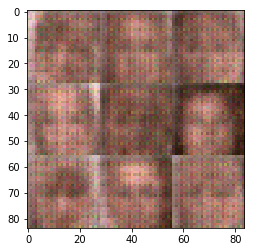

Step 272... Discriminator Loss: 1.5900... Generator Loss: 0.6317
Step 288... Discriminator Loss: 1.5501... Generator Loss: 0.6968
Step 304... Discriminator Loss: 1.5405... Generator Loss: 0.7149
Step 320... Discriminator Loss: 1.5573... Generator Loss: 0.6849


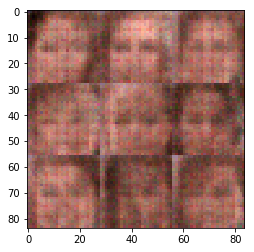

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.